<a href="https://colab.research.google.com/github/jtkernan7/DS-Unit-2-Regression-1/blob/master/JT_sprint6_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import pandas as pd
import requests

project = 'en.wikipedia'
access = 'all-access'
agent = 'user'
article = 'CBD'
granularity = 'daily'
start = '20150701'
end = '20190527'

endpoint = f'/metrics/pageviews/per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'
url = 'https://wikimedia.org/api/rest_v1' + endpoint
response = requests.get(url)
assert response.status_code == 200
df = pd.DataFrame(response.json()['items'])
df = df.rename(columns={'timestamp':'ds', 'views':'y'})
df['ds'] = pd.to_datetime(df['ds'], format='%Y%m%d%H')

In [0]:
from fbprophet import Prophet
import matplotlib.pyplot as plt

In [5]:
df.head()

,access,agent,article,granularity,project,ds,y
0,all-access,user,CBD,daily,en.wikipedia,2015-07-01,100
1,all-access,user,CBD,daily,en.wikipedia,2015-07-02,91
2,all-access,user,CBD,daily,en.wikipedia,2015-07-03,98
3,all-access,user,CBD,daily,en.wikipedia,2015-07-04,81
4,all-access,user,CBD,daily,en.wikipedia,2015-07-05,76


In [0]:
df = df.drop(['access', 'agent', 'article', 'granularity', 'project'], axis=1)

In [8]:
data = df.set_index('ds')
data.sample()

,y
ds,
2017-10-30,119


In [0]:
train = data['2015':'2018']
test  = data['2019']

In [0]:
train = train.reset_index()
test  = test.reset_index()

In [0]:
pd.plotting.register_matplotlib_converters()

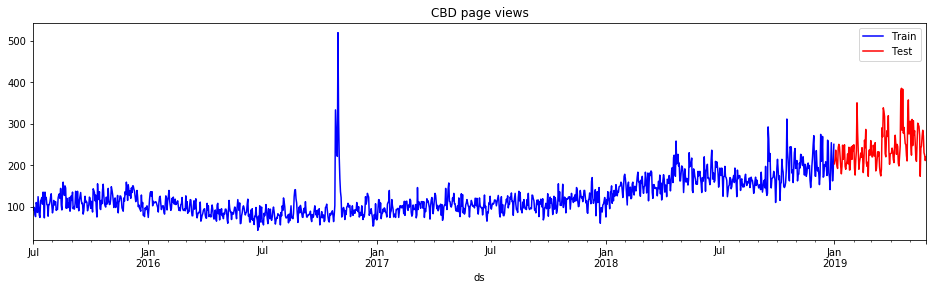

In [22]:
ax = train.plot(x='ds', y='y', color='blue', label='Train', figsize=(16,4))
test.plot(x='ds', y='y', color='red', label='Test', ax=ax)
plt.title('CBD page views');

In [23]:
train['mean_baseline'] = train['y'].mean()
test['mean_baseline']  = train['y'].mean()
print(train['y'].mean())

121.66953125


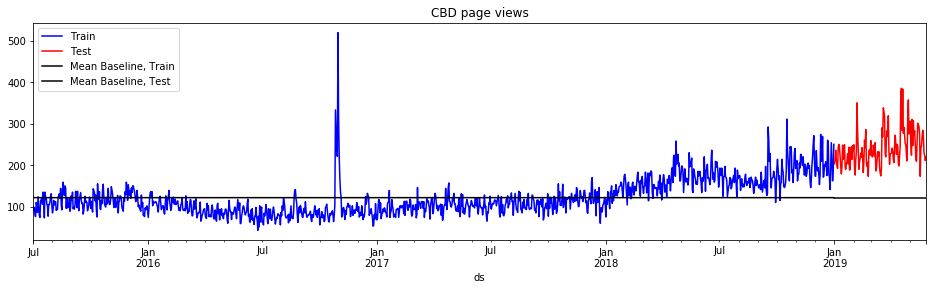

In [24]:
ax = train.plot(x='ds', y='y', color='blue', label='Train', figsize=(16,4))
test.plot(x='ds', y='y', color='red', label='Test', ax=ax)
train.plot(x='ds', y='mean_baseline', color='black', 
           label='Mean Baseline, Train', ax=ax)
test.plot(x='ds', y='mean_baseline', color='black', 
          label='Mean Baseline, Test', ax=ax)
plt.title('CBD page views');

In [0]:
train['naive_baseline'] = train['y'].shift(1).bfill()
train_last_observation = train['naive_baseline'].iloc[-1]
test['naive_baseline'] = train_last_observation

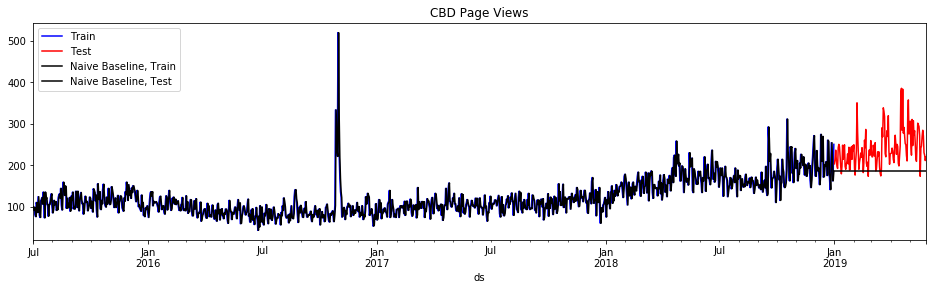

In [26]:
ax = train.plot(x='ds', y='y', color='blue', label='Train', figsize=(16,4))
test.plot(x='ds', y='y', color='red', label='Test', ax=ax)
train.plot(x='ds', y='naive_baseline', color='black', 
           label='Naive Baseline, Train', ax=ax)
test.plot(x='ds', y='naive_baseline', color='black', 
          label='Naive Baseline, Test', ax=ax)
plt.title('CBD Page Views');

In [0]:
from sklearn.metrics import mean_absolute_error

In [28]:
train_mae = mean_absolute_error(train['y'], train['mean_baseline'])
test_mae = mean_absolute_error(test['y'], test['mean_baseline'])
print('Train MAE, for mean baseline:', train_mae)
print('Test MAE, for mean baseline:', test_mae)

Train MAE, for mean baseline: 32.574863281249996
Test MAE, for mean baseline: 118.7862510629252


In [29]:
train_mae = mean_absolute_error(train['y'], train['naive_baseline'])
test_mae = mean_absolute_error(test['y'], test['naive_baseline'])
print('Train MAE, for naive baseline:', train_mae)
print('Test MAE, for naive baseline:', test_mae)

Train MAE, for naive baseline: 17.6421875
Test MAE, for naive baseline: 56.2312925170068


In [0]:
model = Prophet(daily_seasonality=False)
model.fit(train)
train_forecast = model.predict(train)
test_forecast = model.predict(test)

In [0]:
train_forecast.head()

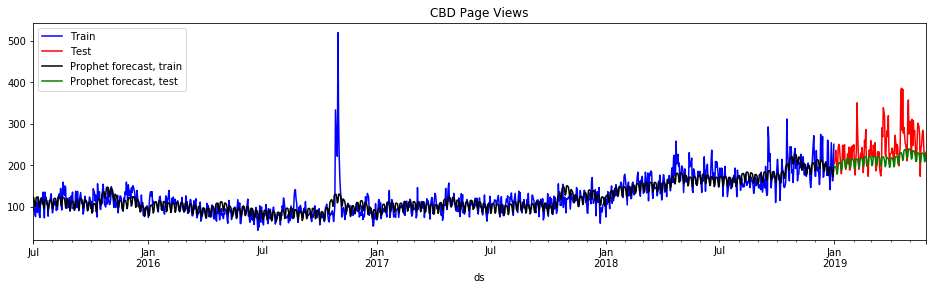

In [32]:
ax = train.plot(x='ds', y='y', color='blue', label='Train', figsize=(16,4))
test.plot(x='ds', y='y', color='red', label='Test', ax=ax)
train_forecast.plot(x='ds', y='yhat', color='black', 
                    label='Prophet forecast, train', ax=ax)
test_forecast.plot(x='ds', y='yhat', color='green', 
                   label='Prophet forecast, test', ax=ax)
plt.title('CBD Page Views');

In [33]:
train_mae = mean_absolute_error(train['y'], train_forecast['yhat'])
test_mae = mean_absolute_error(test['y'], test_forecast['yhat'])
print('Train MAE for Prophet (default params):', train_mae)
print('Test MAE for Prophet (default params):', test_mae)

Train MAE for Prophet (default params): 15.306411892244899
Test MAE for Prophet (default params): 31.540474128032024


In [34]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', 
                         horizon='365 days', period='180 days')

INFO:fbprophet:Making 2 forecasts with cutoffs between 2017-07-04 00:00:00 and 2017-12-31 00:00:00


In [0]:
df_cv.shape

In [0]:
df_cv.describe()

In [38]:
df_cv.describe(exclude='number')

,ds,cutoff
count,730,730
unique,545,2
top,2018-05-18 00:00:00,2017-12-31 00:00:00
freq,2,365
first,2017-07-05 00:00:00,2017-07-04 00:00:00
last,2018-12-31 00:00:00,2017-12-31 00:00:00


In [39]:
from fbprophet.diagnostics import performance_metrics
performance_metrics(df_cv).head()

,horizon,mse,rmse,mae,mape,coverage
0,37 days,609.360036,24.685219,19.578990,0.155999,0.746575
1,38 days,615.439650,24.808056,19.780902,0.157498,0.753425
2,39 days,622.859213,24.957148,20.080175,0.160536,0.753425
3,40 days,650.244349,25.499889,20.640538,0.166026,0.726027
4,41 days,646.583646,25.428009,20.550994,0.165389,0.726027


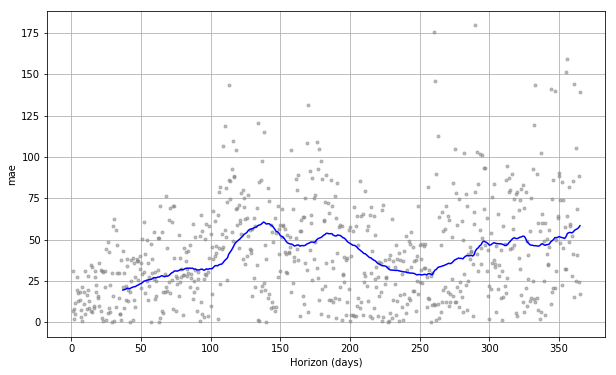

In [40]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')